In [45]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

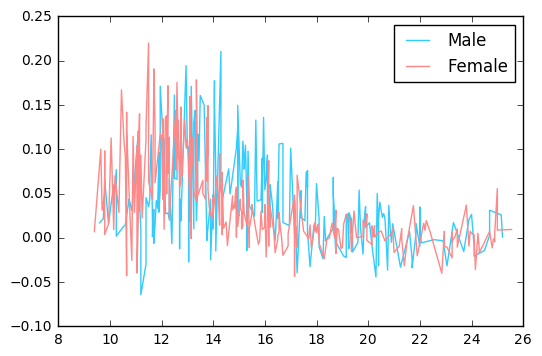

In [202]:
# Data read-in & splitting
df = pd.read_csv('bone.csv')
df_male = df.loc[df['gender'] == 'male', ('age', 'spnbmd')].sort_values(by='age')
df_female = df.loc[df['gender'] == 'female', ('age', 'spnbmd')].sort_values(by='age')
m_x, m_y = df_male['age'].values, df_male['spnbmd'].values
f_x, f_y = df_female['age'].values, df_female['spnbmd'].values


# Wrapper function that superimposes fitting model on original data plots
def plot_model(model=None):
    plt.figure()
    plt.plot(m_x, m_y, color='#33ccff', label='Male')
    plt.plot(f_x, f_y, color='#ff8888', label='Female')
    ret = (model(True), model(False)) if model else None
    plt.legend(loc='upper right')
    plt.show()
    return ret

# Part-I
plot_model()

In [161]:
# Establish knots, segment selectors, and pre-process polynomial features.
m_knots = [np.percentile(m_x, 33), np.percentile(m_x, 67)]
f_knots = [np.percentile(f_x, 33), np.percentile(f_x, 67)]

m_sec = [m_x <= m_knots[0],
         np.logical_and(m_x > m_knots[0], m_x <= m_knots[1]),
         m_x > m_knots[1]]
f_sec = [f_x <= f_knots[0],
         np.logical_and(f_x > f_knots[0], f_x <= f_knots[1]),
         f_x > f_knots[1]]
# model = Pipeline([('poly', PolynomialFeatures(degree=3)),
#                   ('linear', LinearRegression(fit_intercept=True))])
poly2 = PolynomialFeatures(degree=2)
m_base_X_2 = poly2.fit_transform(m_x.reshape((-1, 1)))  # to column vector
f_base_X_2 = poly2.fit_transform(f_x.reshape((-1, 1)))

clf = LinearRegression(fit_intercept=True)

In [165]:
def x_ext_by_knots(base_X, knots, degree):
    # Utility that extends base polynomial features 
    # with truncated polynomial feature corresponds to each knot.
    ext_X = [base_X]
    for k in range(len(knots)):
        x_sub_c = np.maximum(base_X[:, 1] - knots[k], 0)  # element-wise
        new_X = PolynomialFeatures(degree=degree)\
            .fit_transform(x_sub_c.reshape((-1, 1)))
        ext_X.append(new_X[:, 1:])  # first column contains all 1.0
    return np.column_stack(tuple(ext_X))

m_ext_X_2 = x_ext_by_knots(m_base_X_2, m_knots, degree=2)
f_ext_X_2 = x_ext_by_knots(f_base_X_2, f_knots, degree=2)

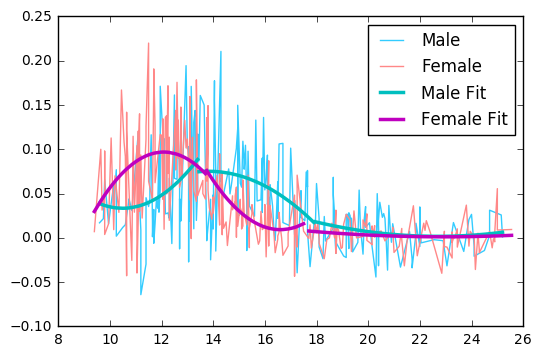

Model Coefficients : Male
      0         1         2
0  0.0 -0.137116  0.006532
1  0.0  0.096198 -0.003480
2  0.0 -0.033140  0.000730

Model Coefficients : Female
      0         1         2
0  0.0  0.225187 -0.009318
1  0.0 -0.272722  0.008215
2  0.0 -0.010980  0.000240


In [217]:
# Part-II

# (a) Fitting Piecewise Quadratic.
def model_a(isMale):
    sec = m_sec if isMale else f_sec
    X = m_base_X_2 if isMale else f_base_X_2
    x = m_x if isMale else f_x
    y = m_y if isMale else f_y
    label = 'Male Fit' if isMale else 'Female Fit'
    beta = []
    for i in range(len(sec)):
        X_, x_, y_ = X[sec[i], :], x[sec[i]], y[sec[i]]
        clf.fit(X_, y_)
        beta.append(clf.coef_)      
        color = 'c' if isMale else 'm'
        if i == 0:
            plt.plot(x_, clf.predict(X_), color, linewidth=2.5, label=label)
        else:
            plt.plot(x_, clf.predict(X_), color, linewidth=2.5)
    return np.row_stack(tuple(beta))
        
beta_male, beta_female = plot_model(model_a)
print('Model Coefficients : Male\n', DataFrame(beta_male))
print('\nModel Coefficients : Female\n', DataFrame(beta_female))

'''
    In the following printed coefficients, each row represents betas that
    correspond to each segment that was separated by knots;
    within each row, there're coefficients of 0, 1, 2 degree, respectively.
'''

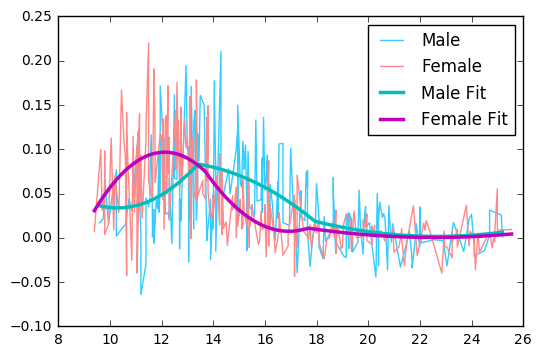

Model Coefficients : Male
 [ 0.         -0.10467476  0.00508438 -0.03630361 -0.00721879  0.0166709
  0.00289784]
Model Coefficients : Female
 [ 0.          0.21568917 -0.00889492 -0.01360501  0.01533947 -0.01386283
 -0.00600492]


In [254]:
# Fitting Continuous Piecewise Quadratic:
def model_b(isMale):
    X = m_ext_X_2 if isMale else f_ext_X_2
    x = m_x if isMale else f_x
    y = m_y if isMale else f_y
    label = 'Male Fit' if isMale else 'Female Fit'
    
    clf.fit(X, y)
    color = 'c' if isMale else 'm'
    plt.plot(x, clf.predict(X), color, linewidth=2.5, label=label)
    return clf.coef_

beta_male, beta_female = plot_model(model_b)
print('Model Coefficients : Male\n', beta_male)
print('Model Coefficients : Female\n', beta_female)

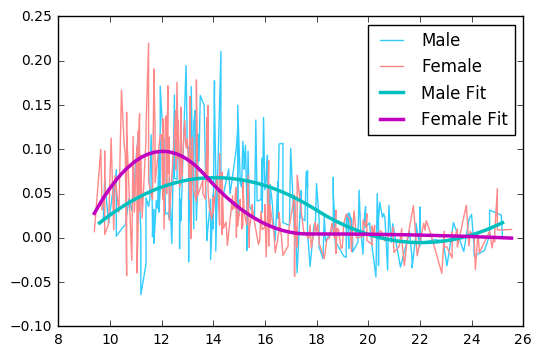

Model Coefficients : Male
 [ 0.          0.07356656 -0.00262529  0.00024123  0.00463245]
Model Coefficients : Female
 [ 0.          0.24130548 -0.01001832  0.01420642 -0.00427274]


In [255]:
# Fitting continuous piecewise quadratic with continuous first derivative:
def model_c(isMale):
    X = m_ext_X_2 if isMale else f_ext_X_2
    x = m_x if isMale else f_x
    y = m_y if isMale else f_y
    label = 'Male Fit' if isMale else 'Female Fit'
    
    X = X[:, [0,1,2,4,6]]  # get rid of degree-1 items
    clf.fit(X, y)
    beta = clf.coef_
    color = 'c' if isMale else 'm'
    plt.plot(x, clf.predict(X), color, linewidth=2.5, label=label)
    return beta

beta_male, beta_female = plot_model(model_c)
print('Model Coefficients : Male\n', beta_male)
print('Model Coefficients : Female\n', beta_female)

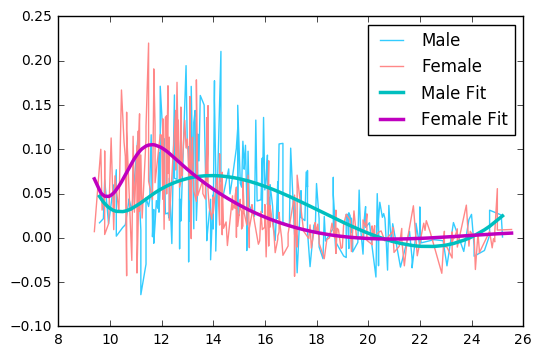

Model Coefficients : Male
 [  0.00000000e+00  -2.77871980e+00   2.45677232e-01  -7.18490718e-03
   7.50396212e-03  -4.72986336e-05]
Model Coefficients : Female
 [  0.         -10.09328578   0.95103489  -0.02971007   0.0397794
  -0.01014546]


In [256]:
poly3 = PolynomialFeatures(degree=3)
m_base_X_3 = poly3.fit_transform(m_x.reshape((-1, 1)))  # to column vector
f_base_X_3 = poly3.fit_transform(f_x.reshape((-1, 1)))
m_ext_X_3 = x_ext_by_knots(m_base_X_3, m_knots, degree=3)
f_ext_X_3 = x_ext_by_knots(f_base_X_3, f_knots, degree=3)


# Fitting continuous piecewise quadratic with continuous first derivative:
def model_d(isMale):
    X = m_ext_X_3 if isMale else f_ext_X_3
    x = m_x if isMale else f_x
    y = m_y if isMale else f_y
    label = 'Male Fit' if isMale else 'Female Fit'
    
    X = X[:, [0,1,2,3,6,9]]  # get rid of degree-1 & -2 items
    clf.fit(X, y)
    beta = clf.coef_
    color = 'c' if isMale else 'm'
    plt.plot(x, clf.predict(X), color, linewidth=2.5, label=label)
    return beta

beta_male, beta_female = plot_model(model_d)
print('Model Coefficients : Male\n', beta_male)
print('Model Coefficients : Female\n', beta_female)

     Female      Male
2  0.001396  0.017062
3  0.075044  0.043720
4  0.007160  0.002752
5  0.007232  0.010092
6  0.005885  0.025795
7  0.002663  0.146218


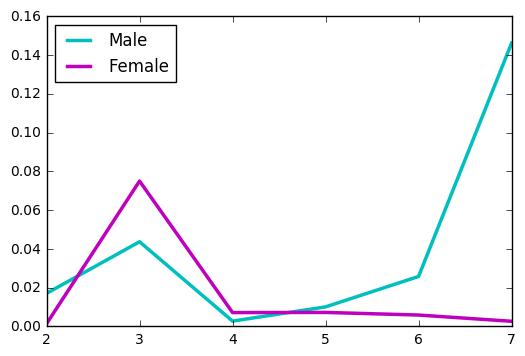

In [267]:
# Part-III

col_selector = [0, 1, 2, 4, 6]  # same to model_c
clf = LinearRegression(fit_intercept=True)
ploy2 = PolynomialFeatures(degree=2)
m_scores, f_scores = [], []
NMSE = 'neg_mean_squared_error'

for n_knots in range(2, 8):
    width = 100 // (n_knots + 1)
    # Male model part
    m_knots = [np.percentile(m_x, i * width) for i in range(1, n_knots+1)]
    m_base_X = ploy2.fit_transform(m_x.reshape((-1, 1)))
    m_ext_X = x_ext_by_knots(m_base_X, m_knots, 2)[:, col_selector]
    m_scores.append(- cross_val_score(clf, m_ext_X, m_y, scoring=NMSE, cv=5).mean())
    # Female model part
    f_knots = [np.percentile(f_x, i * width) for i in range(1, n_knots+1)]
    f_base_X = ploy2.fit_transform(f_x.reshape((-1, 1)))
    f_ext_X = x_ext_by_knots(f_base_X, f_knots, 2)[:, col_selector]
    f_scores.append(- cross_val_score(clf, f_ext_X, f_y, scoring=NMSE, cv=5).mean())

print(DataFrame({'Male': m_scores, 'Female': f_scores}).set_index([list(range(2, 8))]))

# Plot the curve of both models
plt.figure()
plt.plot(range(2, 8), m_scores, color='c', linewidth=2.5, label='Male')
plt.plot(range(2, 8), f_scores, color='m', linewidth=2.5, label='Female')
plt.legend(loc='upper left')
plt.show()

# 
#     As can be cleared seen,
#     n_knots=4 fits male model best,
#     while n_knots=2 fits female model best.
#